In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype


In [97]:
#Processing the dataframe and dropping NaN rows
def age_category(age):
  if age < 10:
    return 0
  elif age > 9 and age < 16:
    return 1
  elif age < 20:
    return 2
  elif age < 25:
    return 3
  elif age < 35:
    return 4
  elif age < 45:
    return 5
  elif age < 55:
    return 6
  elif age < 65:
    return 7
  elif age < 75:
    return 8
  elif age > 74:
    return 9

age_type = CategoricalDtype(categories=[0,1,2,3,4,5,6,7,8,9], ordered=True)
d = pd.read_csv("habits.data", sep=";", na_values="?")

d.kohde = d.kohde.astype('category')
d.jasen = d.jasen.astype('category')
d.pvknro = d.pvknro.map({1:'weekday', 2:'weekend'})
d.pvknro = d.pvknro.astype('category')
d.sp = d.sp.map({1:'man', 2:'woman'})
d.sp = d.sp.astype('category')
d.ASALUE = d.ASALUE.map({1:'city', 2:'municipality', 3:'rural'})
d.ASALUE = d.ASALUE.astype('category')
d.IKAL1 = d.IKAL1.apply(age_category)
d.IKAL1 = d.IKAL1.astype(age_type)
d.A1 = pd.to_numeric(d['A1'], errors='coerce')
d.A2 = pd.to_numeric(d['A2'], errors='coerce')
d.A3 = pd.to_numeric(d['A3'], errors='coerce')
d.A4 = pd.to_numeric(d['A4'], errors='coerce')
d.A5 = d.A5.map({1:'yes', 2:'no'})
d.A5 = d.A5.astype('category')
d.rename(columns={'A1': 'working', 'A2': 'sleeping', 'A3': 'reading', 'A4': 'restaurant', 'A5': 'library'}, inplace=True)
print(d.dtypes)

print(d.isnull().sum())
print(d.shape)

d = d.dropna()
print(d.shape)

kohde         category
jasen         category
pvknro        category
sp            category
ASALUE        category
IKAL1         category
working        float64
sleeping       float64
reading        float64
restaurant     float64
library       category
dtype: object
kohde          0
jasen          0
pvknro         0
sp             0
ASALUE         0
IKAL1          0
working       85
sleeping      88
reading       94
restaurant    91
library       62
dtype: int64
(745, 11)
(584, 11)


In [98]:
#Characterizing the individuals and activities
for col in ['pvknro', 'sp', 'ASALUE', "IKAL1", 'library']:
  print(f"\n{col}:\n", d[col].value_counts(normalize=True).round(2))

print(d[['working', 'sleeping', 'reading', 'restaurant']].describe().round(2))
print(d[['working', 'sleeping', 'reading', 'restaurant']].median().round(2))


pvknro:
 pvknro
weekday    0.51
weekend    0.49
Name: proportion, dtype: float64

sp:
 sp
woman    0.53
man      0.47
Name: proportion, dtype: float64

ASALUE:
 ASALUE
city            0.62
rural           0.21
municipality    0.17
Name: proportion, dtype: float64

IKAL1:
 IKAL1
7    0.26
6    0.23
5    0.16
4    0.14
8    0.11
9    0.07
3    0.03
0    0.00
1    0.00
2    0.00
Name: proportion, dtype: float64

library:
 library
yes    0.7
no     0.3
Name: proportion, dtype: float64
       working  sleeping  reading  restaurant
count   584.00    584.00   584.00      584.00
mean    121.52    518.42    47.48       47.95
std     207.21     98.76    63.43       58.48
min       0.00     70.00     0.00        0.00
25%       0.00    460.00     0.00        0.00
50%       0.00    510.00    30.00        0.00
75%     212.50    580.00    70.50      100.00
max     760.00    900.00   474.00      240.00
working         0.0
sleeping      510.0
reading        30.0
restaurant      0.0
dtype: float64


based on these descriptive statistics the number of samples from weekdays and weekends are almost equal 51% weekday, 49% weekend. 
This is also true for the genders which are almost equally divided 53% women, 47% men.

Most of the people live in a city 62%, while the rest live in rural 21% and in municipalities 17%
Most people 49% fall into the age ranges of 7(55-64 Years) 26% and 6(45-54 Years) 23%. There are no people in the age ranges of 0 (<10 Years), 1(10-14 Years) and 2(15-19 Years)
Most people have visited the library within the past year 70%

The average time for the following activities of working, sleeping, reading and dining out are: 121.5 min, 518.4 min, 47.5 min, 47.9 min
The median time for the following activities of working, sleeping, reading and dining out are: 0 min, 510 min, 30 min, 0 min

The standard deviations of the activities are all large >58, which indicates that there are several quite different characters present in the data.

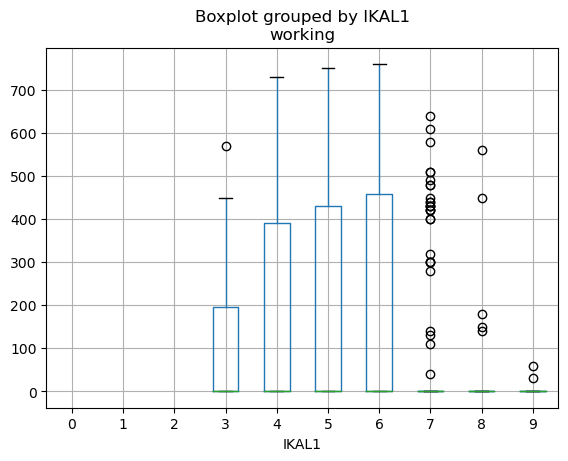

In [99]:
d.boxplot(column='working', by='IKAL1')
plt.show()

When using a boxplot that show the time of minutes spent working by the age group, it seems that there is a sharp drop in the number of minutes worked
between the groups 6 and 7. This indicates that the data is split into working people 46% and retired people 54%.

In [133]:
#Estimating how much time on average do Finnish household spend daily on each activity
kohde_df = d.groupby(by=['kohde'], observed=False)
kohde_df = kohde_df.describe().describe()


In [144]:
print(f"working mean: {kohde_df['working']['mean']['mean'].round(2)}")
print(f"sleeping mean: {kohde_df['sleeping']['mean']['mean'].round(2)}")
print(f"reading mean: {kohde_df['reading']['mean']['mean'].round(2)}")
print(f"restaurant mean: {kohde_df['restaurant']['mean']['mean'].round(2)}")

working mean: 122.43
sleeping mean: 519.12
reading mean: 47.81
restaurant mean: 48.85


The average ammount that a finnish household does the following activities of working, sleeping, reading and eating at a restaurant are: 122 min, 519 min, 48 min and 49 min

These averages don't give a robust understanding of all finnish households, because in some households there are no working people and is some households, people work. This means that the average situation is low for working people and high for retired people. This is because the data is not grouped by age by default.

In [ ]:
#With respect to which activities do living environments or days of weeks differ in Finland?
